In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap

In [2]:
cb_classifier = CatBoostClassifier()

cb_classifier.load_model("catboost_info/best_model.cbm")

In [3]:
train = pd.read_csv("data/training.csv")
validation = pd.read_csv("data/validation.csv")
test = pd.read_csv("data/test.csv")

def splitMonthYear(monthyears):
    month_list = []
    year_list = []
    for monthyear in monthyears:
        month, year = monthyear.split()
        month_list.append(month.lower())
        year_list.append(year)
    return month_list, year_list

train["Month"], train["Year"] = splitMonthYear(train["MonthYear"])
validation["Month"], validation["Year"] = splitMonthYear(validation["MonthYear"])
test["Month"], test["Year"] = splitMonthYear(test["MonthYear"])

train.drop(columns=["Animal ID", "Name",
                    "DateTime", "MonthYear",
                    "Found Location"], inplace=True)
validation.drop(columns=["Animal ID", "Name",
                         "DateTime", "MonthYear",
                         "Found Location"], inplace=True)
test.drop(columns=["Animal ID", "Name",
                   "DateTime", "MonthYear",
                   "Found Location"], inplace=True)

train_y = train["Days"].values
train = train.drop(columns="Days")
validation_y = validation["Days"].values
validation = validation.drop(columns="Days")
test_y = test["Days"].values
test = test.drop(columns="Days")

for c in ["Intake Type", "Intake Condition", "Animal Type",
          "Sex upon Intake", "Breed", "Color", "Month", "Year"]:
    train[c] = train[c].astype("category")
    validation[c] = validation[c].astype("category")
    test[c] = test[c].astype("category")

train["Age upon Intake"] = train["Age upon Intake"].astype("float")
validation["Age upon Intake"] = validation["Age upon Intake"].astype("float")
test["Age upon Intake"] = test["Age upon Intake"].astype("float")

Validation results:

In [4]:
y_pred = cb_classifier.predict(validation)

print(classification_report(validation_y, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2285
           1       0.80      0.79      0.79      2600

    accuracy                           0.78      4885
   macro avg       0.78      0.78      0.78      4885
weighted avg       0.78      0.78      0.78      4885



Test results:

In [5]:
y_pred = cb_classifier.predict(test)

print(classification_report(test_y, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2285
           1       0.80      0.82      0.81      2599

    accuracy                           0.79      4884
   macro avg       0.79      0.79      0.79      4884
weighted avg       0.79      0.79      0.79      4884



Feature importance: https://catboost.ai/en/docs/concepts/fstr#regular-feature-importance

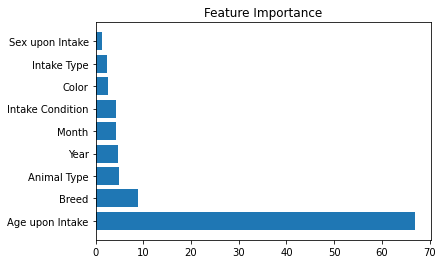

In [6]:
cat_features = [0, 1, 2, 3, 5, 6, 7, 8]

feature_importance = cb_classifier.get_feature_importance(Pool(test,
                                                               label=test_y,
                                                               cat_features=cat_features),
                                                          type="PredictionValuesChange")
sorted_idx = feature_importance.argsort()[::-1][:len(feature_importance)]
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.savefig("figures/feature_importance.png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
plt.show()

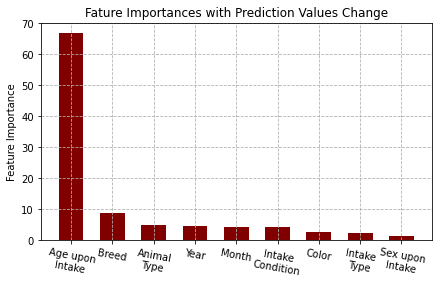

In [7]:
fig = plt.figure(figsize = (7, 4))

values = np.array(test.columns)[sorted_idx]
values[0] = values[0].split()[0] + " " + values[0].split()[1] + "\n" + values[0].split()[2]
values[2] = values[2].split()[0] + "\n" + values[2].split()[1]
values[5] = values[5].split()[0] + "\n" + values[5].split()[1]
values[7] = values[7].split()[0] + "\n" + values[7].split()[1]
values[8] = values[8].split()[0] + " "  + values[8].split()[1] + "\n" + values[8].split()[2]

plt.bar(values,
        feature_importance[sorted_idx],
        color ='maroon', width = 0.6)

plt.ylabel("Feature Importance")
plt.title("Fature Importances with Prediction Values Change")
plt.grid(linestyle='--')
plt.savefig("figures/feature_importance_pred_values_change.png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.02,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
plt.xticks(rotation=-10)
plt.show()

SHAP Values:

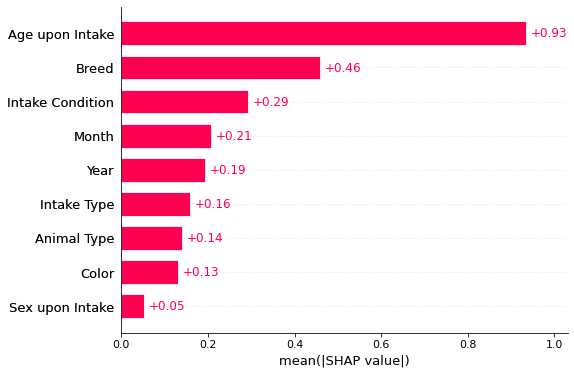

<Figure size 432x288 with 0 Axes>

In [10]:
explainer = shap.Explainer(cb_classifier)

shap_values = explainer(test)
shap.plots.bar(shap_values)
plt.show()